In [4]:
from collections import defaultdict
from functools import partial
from glob import glob
from itertools import count
from math import asin
from math import atan
from math import atan2
from math import cos
from math import asin
from math import radians
from math import sin
from math import sqrt
from math import tan
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

from geopandas import GeoDataFrame
from numpy.typing import ArrayLike
from numpy.typing import NDArray
from numpy import float64
from pandas import DataFrame
from pandas import DatetimeIndex
from pandas import NamedAgg
from pandas import read_csv
from pandas import Series
from pandas import to_datetime
from scipy.interpolate import pchip_interpolate
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from skmob import TrajDataFrame


In [5]:
def earth_radius_m(B: float) -> float:
    """calculates the Earth's radius (m) at a given latitude using an ellipsoidal model. 
    Major/minor axes are from NASA.

    Args:
        latitudes (NDArray[float_]): array of latitude values (degrees)

    Returns:
        NDArray[float_]: Earth's radius (m) for each latitude value
    """

    r_1 = 6378137 # Earth's radius at the equator (m)
    r_2 = 6356752 # Earth's radius at the poles (m)
    B = radians(B) # latitude values in radians
    g = (r_1**2 * cos(B))**2 + (r_2**2 * sin(B))**2
    f = (r_1 * cos(B))**2 + (r_2 * sin(B))**2
    R = sqrt(g / f)
    return R

def haversine(point_1: Series, point_2: Series) -> float:

    radius_m = earth_radius_m(point_1.LAT)

    latitude_1, longitude_1 = radians(point_1.LAT), radians(point_1.LON)
    latitude_2, longitude_2 = radians(point_2.LAT), radians(point_2.LON)

    dist_longitude = longitude_2 - longitude_1
    dist_latitude = latitude_2 - latitude_1

    a = sin(dist_latitude / 2.0)**2 + cos(latitude_1) * cos(latitude_2) * sin(dist_longitude / 2.0)**2
    c = 2 * asin(sqrt(a))

    return radius_m * c


In [236]:
def TDBSCAN(data: DataFrame, c_eps: int, eps: int, min_points: int) -> DataFrame:
    """performs decomposition of a trajectory into a series of stops and moves, AKA
    stay point detection. T-DBSCAN (acronym for Trajectory DBSCAN) was developed by 
    extending and modifying the formal definitions of DBSCAN from the basic concepts 
    of GPS based trajectories.

    T-DBSCAN: A Spatiotemporal Density Clustering for GPS Trajectory Segmentation
    W. Chen, M. H. Ji1 & J. M. Wang

    Args:
        data (DataFrame): trajectory DataFrame
        c_eps (int): distance range (m) to ensure the points comprising a stop are of state continuity
        eps (int): search radius identifying density-based neighbourhood
        min_points (int): minimum number of neighbouring points identifying a core point

    Raises:
        ValueError: if LAT, LON & EPOCH columns are not present

    Returns:
        D (DataFrame): trajectory DataFrame with stops labelled in CLUSTER column
    """
    POINT_COLUMNS = ["LAT", "LON", "EPOCH"]
    if not set(data.columns).issuperset(POINT_COLUMNS):
        raise ValueError("DataFrame must contain LAT, LON & EPOCH columns")

    D = (data
            .assign(CLUSTER=0, PROCESSED=False)
            .sort_values(by="EPOCH")
            .reset_index(drop=True)
            .astype({"CLUSTER": "int16"}))

    # Numpy structured array
    #D = np.array([tuple(i) for i in D.values], dtype=list(zip(D.dtypes.index, D.dtypes)))

    # integer location for PROCESSED & CLUSTER columns
    PROCESSED_LOC = D.columns.get_loc("PROCESSED")
    CLUSTER_LOC = D.columns.get_loc("CLUSTER")

    def search_CDBN(D: DataFrame, point_index: int, c_eps: int = c_eps, eps: int = eps) -> set:
        """
        """
        print(" search_CDBN")
        point = D[POINT_COLUMNS].iloc[point_index]
        N = set([point_index])
        for neighbour_index in D.index[point_index+1:]:
            print(f"  -> neighbour_index {neighbour_index} is processed: {D.iat[neighbour_index, PROCESSED_LOC]}")
            neighbour_point = D[POINT_COLUMNS].iloc[neighbour_index]
            distance_m = haversine(point, neighbour_point)
            if distance_m <= eps:
                print(f"  -> neighbour_index {neighbour_index} distance <= eps: {distance_m <= eps}")
                N.add(neighbour_index)
            elif distance_m >= c_eps:
                print(f"  -> neighbour_index {neighbour_index} distance >= c_eps: {distance_m >= c_eps}")
                break

        return N

    def expand_cluster(D: DataFrame, point_index: int, N: set[int], max_index: int, min_points: int = min_points) -> int:

        """
        (Cp,MaxId) = expandCluster (P, N, Eps, MinPts, MaxId)
        add P to cluster Cp
        for each point P' in N
            mark P' as visited
            if id of P' > MaxId
                Maxid = id of P'
            endif

            N' = getNeighbors(P', CEps, Eps)
            if sizeof(N') >= MinPts
                classify the points into current cluster based on definition 3,4,5
                N = N joined with N'
            endif
            
            if P' is not yet member of any cluster
                add P' to cluster Cp
            endif
        endfor
        """

        print(f" expand_cluster -> point_index: {point_index}, N: {N}")
        current_neighbour = 0
        while current_neighbour < len(N):
            neighbour_index = sorted(N)[current_neighbour]

            print(f"  -> N length: {len(N)}")
            print(f"  -> neighbour_index: {neighbour_index}, max_index: {max_index}, cluster: {D.iat[neighbour_index, CLUSTER_LOC]}")

            D.iat[neighbour_index, PROCESSED_LOC] = True

            if neighbour_index > max_index:
                max_index = neighbour_index

                N1 = search_CDBN(D, neighbour_index)
                print(f"   -> N1 length: {len(N1)}, min_points: {min_points}")
                if len(N1) >= min_points:
                    N = N.union(N1)
                if D.iat[neighbour_index, CLUSTER_LOC] == 0:
                    D.iat[neighbour_index, CLUSTER_LOC] = D.iat[point_index, CLUSTER_LOC]

            current_neighbour +=1
                
        return max_index
    # ID of the cluster being searched
    C = 0

    # as the points of a trajectory are time ordered, the points with an index < than max_index 
    # are either identified as noise or belong to the previous cluster. Only points where the 
    # index > max_index are processed.
    max_index = -1

    for point_index in D.index:
        print(f"point_index: {point_index}, max_index: {max_index}")
        if point_index > max_index:
            # mark current point as PROCESSED
            D.iat[point_index, PROCESSED_LOC] = True

            N = search_CDBN(D, point_index)
            print(f"N length: {len(N)}, min_points: {min_points}")
            max_index = point_index
            if len(N) >= min_points:
                C += 1
                D.iat[point_index, CLUSTER_LOC] = C
                max_index = expand_cluster(D, point_index, N, max_index)
            else:
                print("not expand_cluster")
                D.iat[point_index, CLUSTER_LOC] = -1

        print("")

    return D

In [ ]:
def T_DBSCAN(trajectory_data: DataFrame, c_eps, eps, min_pts: int) -> DataFrame:
    """_summary_

    Args:
        trajectory_data (DataFrame): DataFrame of trajectory data
        c_eps (_type_): distance range to ensure points comprising a stop are continuous
        eps (_type_): search radius for identifying density-based neighborhood
        min_pts (int): minimum neighbouring points to identify a core point
    """
    TRAJ_COLUMNS = ["LAT", "LON", "EPOCH"]
    if not set(trajectory_data.columns).issuperset(TRAJ_COLUMNS):
        raise ValueError("DataFrame must contain LAT, LON, EPOCH columns")

    def CDBN(D: DataFrame, CP: Series, CP_idx: int, c_eps, eps) -> list:
        """Search for continuous density-based neighborhood

        Args:
            D (DataFrame): _description_
            CP (list[float]): _description_
            c_eps (int): _description_
            eps (_type_): _description_
            p_idx (int): _description_

        Returns:
            N (list): _description_
        """
        if not set(D.columns).issuperset(TRAJ_COLUMNS):
            raise ValueError("DataFrame must contain LAT, LON, EPOCH columns")
        N = []
        for idx, point in D.iterrows():
            if idx > CP_idx: # type: ignore
                distance_m = haversine(CP, point)
                if distance_m < eps:
                    N.append(idx)
                elif distance_m > c_eps:
                    break
        return N
    
    def expand_cluster(D: DataFrame, N: list, CP_idx: int, max_id: int, c_eps, eps, min_pts: int):
        C_points = [CP_idx]
        for idx in N:
            point = D.iloc[idx]
            if idx > max_id:
                max_id = idx
            
            # search for continuous density-based neighbours
            N_2 = CDBN(D, point, idx, c_eps, eps)
            # add points into current cluster
            if len(N_2) >= min_pts:
                N += N_2
            if idx not in C_points:
                C_points.append(idx)

        return C_points, max_id
    
    def merge_clusters(C_points: defaultdict[int, list]) -> defaultdict:
        first_C, *remaining_C = C_points.keys()
        C_points_merged = defaultdict(list)
        C_points_merged[first_C].extend(C_points[first_C])

        for C in remaining_C:
            last_C_merged = list(C_points_merged)[-1]

            # new cluster = new C_points_merged entry
            if max(C_points_merged[last_C_merged]) <= min(C_points[C]):  # type: ignore
                C_points_merged[last_C_merged+1].extend(C_points[C])
            # merge last item in the buffer with C_points
            else: 
                C_points_merged[last_C_merged].extend(C_points[C])

        return C_points_merged
    
    def label_clusters(D: DataFrame, C_points: defaultdict[int, float]) -> DataFrame:
        for C, C_points_idx in C_points.items():
            D.loc[C_points_idx, "CLUSTER"] = C
        return D

    # DataFrame of points comprising the trajectory
    D = (
        trajectory_data
            .assign(
                CLUSTER=np.nan,
                PROCESSED=False
            )
            .sort_values(by="EPOCH")
            .reset_index(drop=True)
            .astype({"CLUSTER": "Int32"})
    )

    # ID of cluster currently being searched
    C = 0
    # the maximum id of the visited point
    max_id = -1

    # Because the points of a trajectory are time ordered, the points with an ID 
    # smaller than MaxId are supposed to either belong to the previous cluster 
    # (the points unvisited but during the time extent of a cluster also belong 
    # to the cluster) or identified as noise. So here only the points with an ID 
    # greater than MaxId are processed, and this helps to improve the efficiency 
    # of the method.

    # point set of a cluster with ID of C
    C_points = defaultdict(list)
    
    for idx, point in D[TRAJ_COLUMNS].iterrows():
        print(f"idx: {idx}, C: {C}")
        if idx > max_id: # type: ignore
            # mark current point as processed
            D.loc[idx, "PROCESSED"] = True # type: ignore
        
            print("Searching for continuous density-based neighbours")
            # search for continuous density-based neighbours
            N = CDBN(D[TRAJ_COLUMNS], point, idx, c_eps, eps) # type: ignore
            max_id = idx
            # create new cluster
            if len(N) > min_pts:
                C += 1

            print("Expanding clusters")
            C_points_temp, max_id = expand_cluster(D[TRAJ_COLUMNS], N, idx, max_id, c_eps, eps, min_pts) # type: ignore

            # mark neighbourhood N points as processed
            D.loc[N, "PROCESSED"] = True

            if C in C_points:
                C_points[C].extend(C_points_temp)                          
            else:
                C_points[C] = C_points_temp

    print("Merging clusters")
    C_points = merge_clusters(C_points)
    D = label_clusters(D, C_points)

    return D.drop(columns="PROCESSED")

In [ ]:
def vincenty(point1: NDArray, point2: NDArray) -> float:
    """Calculate the distance between two points of longitude/latitude using the
    Vincenty inverse approach. This is more accurate than the Haversine method, 
    however because of its iterative nature, it carries with it an increased 
    computational cost.

    Args:
        point1 (_type_): _description_
        point2 (_type_): _description_

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    MAX_ITERATIONS = 200
    # .000,000,000,001
    CONVERGENCE_THRESHOLD = 1e-12  

    # length of semi-major axis of the ellipsoid aka radius of the equator in meters
    a = 6378137
    # flattening of the ellipsoid (WGS-84). measure of the compression of a circle or sphere 
    # along a diameter to form an ellipse or an ellipsoid of revolution (spheroid) respectively 
    f = 1 / 298.257223563
    # length of semi-minor axis of the ellipsoid (radius at the poles, 6356752.314245 meters in WGS-84)
    b = 6356752.314245

    # short-circuit coincident points
    if point1[0] == point2[0] and point1[1] == point2[1]:
        return 0.0

    U1 = atan((1 - f) * tan(radians(point1[0])))
    U2 = atan((1 - f) * tan(radians(point2[0])))
    L = radians(point2[1] - point1[1])
    Lambda = L

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    sinU2 = sin(U2)
    cosU2 = cos(U2)

    for iteration in range(MAX_ITERATIONS):
        sinLambda = sin(Lambda)
        cosLambda = cos(Lambda)
        sinSigma = sqrt((cosU2 * sinLambda) ** 2 +
                             (cosU1 * sinU2 - sinU1 * cosU2 * cosLambda) ** 2)
        if sinSigma == 0:
            return 0.0  # coincident points
        cosSigma = sinU1 * sinU2 + cosU1 * cosU2 * cosLambda
        sigma = atan2(sinSigma, cosSigma)
        sinAlpha = cosU1 * cosU2 * sinLambda / sinSigma
        cosSqAlpha = 1 - sinAlpha ** 2
        try:
            cos2SigmaM = cosSigma - 2 * sinU1 * sinU2 / cosSqAlpha
        except ZeroDivisionError:
            cos2SigmaM = 0
        C = f / 16 * cosSqAlpha * (4 + f * (4 - 3 * cosSqAlpha))
        LambdaPrev = Lambda
        Lambda = L + (1 - C) * f * sinAlpha * (sigma + C * sinSigma *
                                               (cos2SigmaM + C * cosSigma *
                                                (-1 + 2 * cos2SigmaM ** 2)))
        # if successful convergence
        if abs(Lambda - LambdaPrev) < CONVERGENCE_THRESHOLD:
            break
    else:
        raise ValueError("Failure to converge")

    uSq = cosSqAlpha * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + uSq / 16384 * (4096 + uSq * (-768 + uSq * (320 - 175 * uSq)))
    B = uSq / 1024 * (256 + uSq * (-128 + uSq * (74 - 47 * uSq)))
    deltaSigma = B * sinSigma * (cos2SigmaM + B / 4 * (cosSigma *
                 (-1 + 2 * cos2SigmaM ** 2) - B / 6 * cos2SigmaM *
                 (-3 + 4 * sinSigma ** 2) * (-3 + 4 * cos2SigmaM ** 2)))
    s = b * A * (sigma - deltaSigma)

    # meters to kilometers
    s /= 1000

    return round(s, 6)


In [ ]:
def trajectory_vincenty_distance(trajectory_data: DataFrame) -> NDArray[float64]:
    """Calculate the distance in meters (Vincenty formula) between each 
    coordinate pair within the trajectory DataFrame.

    Args:
        trajectory_data (DataFrame): raw trajectory dataframe

    Returns:
        NDArray[float64]: distances in meters
    """
    trajectory_length = len(trajectory_data.LAT)
    trajectory_distance = np.zeros(trajectory_length)
    for idx in range(trajectory_length - 1):
        point_1 = trajectory_data[["LAT", "LON"]].iloc[idx].to_numpy()
        point_2 = trajectory_data[["LAT", "LON"]].iloc[idx+1].to_numpy()
        meters = vincenty(point_1, point_2) * 1000  # unit meter
        trajectory_distance[idx + 1] = meters

    return trajectory_distance


In [ ]:
def trajectory_epoch_distance(trajectory_data: DataFrame) -> NDArray[float64]:
    """Calculate the distance in seconds between each timestamp for 
    all points within the trajectory DataFrame.

    Args:
        trajectory_data (DataFrame): raw trajectory dataframe

    Returns:
        NDArray[float64]: distances in seconds
    """
    
    trajectory_length = len(trajectory_data.LAT)
    trajectory_distance = np.zeros(trajectory_length)
    for idx in range(trajectory_length - 1):
        seconds = int(trajectory_data.EPOCH.iloc[idx + 1]) - int(trajectory_data.EPOCH.iloc[idx])
        trajectory_distance[idx + 1] = seconds
    return trajectory_distance


In [ ]:
def trajectory_PCHIP(trajectory_data: DataFrame, time_resolution: float = 30.0, num: Optional[int] = None) -> DataFrame:
    """Interpolate GPS trajectory data using the Piecewise Cubic Hermite Interpolating 
    Polynomial (PCHIP) algorithm. Compared with other interpolation algorithms, PCHIP can 
    not only correctly preserve the shape and change trend of a trajectory, but also take 
    into account the smoothness.

    Args:
        trajectory_data (DataFrame): raw trajectory dataframe
        time_resolution (float, optional): time resolution. Defaults to 60.0
        num (int, optional): Defaults to None

    Raises:
        ValueError: if time_resolution <= 0.0
        ValueError: if num is < 0 and not None

    Returns:
        merged_trajectory_data: trajectory_data merged with interpolated data
    """

    if time_resolution <= 0.0:
        raise ValueError('res must be > 0.0')
    if num is not None and num < 0:
        raise ValueError('num must be >= 0')
    
    trajectory_distance = trajectory_epoch_distance(trajectory_data)
    #trajectory_distance = trajectory_vincenty_distance(trajectory_data)

    xi = np.cumsum(trajectory_distance)
    yi = trajectory_data[["LAT", "LON", "EPOCH"]].values.T

    if num is None:
        num = int(np.ceil(xi[-1] / time_resolution))

    x = np.linspace(xi[0], xi[-1], num=num, endpoint=True)
    y = pchip_interpolate(xi, yi, x, axis=1)

    if not isinstance(y, np.ndarray):
        raise ValueError("PCHIP output not NDArray")
    
    interpolated_data = (
        DataFrame(data=y.T, columns=["LAT", "LON", "EPOCH"])
            .assign(VESSEL_ID=trajectory_data.VESSEL_ID.iloc[0])
            .astype({"EPOCH": "int64"})
    )

    merge_map = {"both": False, "left_only": False, "right_only": True}
    merged_trajectory_data = (
        trajectory_data
            .merge(right=interpolated_data, how="outer", indicator="INTERPOLATED")
            .pipe(lambda df_: df_.assign(INTERPOLATED=df_.INTERPOLATED.map(merge_map)))
            .sort_values(by="EPOCH")
            .reset_index(drop=True)
    )

    return merged_trajectory_data

In [ ]:
def trajectory_PCHIP_segmentation(trajectory_data: DataFrame) -> DataFrame:
    """Segment a trajectory by consecutive INTERPOLATED column values, where
    values are True. Each segment is assigned an ID within the INTERPOLATED_ID
    column, provided the segment has at least two rows.

    Args:
        trajectory_data (DataFrame): interpolated DataFrame (PCHIP)

    Raises:
        ValueError: if INTERPOLATED column is missing

    Returns:
        DataFrame: DataFrame with highlighted interpolated segments
    """
    if "INTERPOLATED" not in trajectory_data.columns:
        raise ValueError("trajectory_data has not been interpolated")
    
    # create INTERPOLATED_ID to store individual segment ID
    segmented_data = trajectory_data.assign(INTERPOLATED_ID=np.nan)
    # create mask to facilitate filtering and cumsum of inverse of filter
    interp_mask = segmented_data.INTERPOLATED==True
    for key, group in segmented_data[interp_mask].groupby((~interp_mask).cumsum()):
        if len(group) < 2:
            continue
        segmented_data.loc[group.index, "INTERPOLATED_ID"] = key
    return trajectory_data
    
    

In [ ]:
def trajectory_epoch_segmentation(trajectory_data: DataFrame, time_interval: int) -> DataFrame:
    """Segment a trajectory where difference in EPOCH column values > time_interval (True). 
    Each segment is assigned an ID in the SEGMENT_ID. Used as a preliminary step before stay
    point identification.

    Args:
        trajectory_data (DataFrame): trajectory DataFrame
        time_interval (int): time interval to segment trajectory

    Returns:
        DataFrame: segmented DataFrame
    """
    segmented_data: DataFrame = (
        trajectory_data
            .pipe(lambda df_:
                df_.assign(
                    SEGMENT_ID=np.nan,
                    INTERVAL=df_.EPOCH.diff().fillna(0)
                )
            )
            .astype({"SEGMENT_ID": "Int32"})
    )

    interval_mask = segmented_data.INTERVAL > time_interval
    for key, group in segmented_data[interval_mask].groupby((~interval_mask).cumsum()):
        segmented_data.loc[group.index, "SEGMENT_ID"] = key

    return segmented_data.drop(columns="INTERVAL")

In [6]:
data_files = glob("./data/unipi_ais/synopses/2018/*.csv")

In [7]:
raw_data = (
    read_csv(data_files[0])
        .rename(columns=str.upper)
        .rename(columns={"T": "EPOCH"})
        .pipe(lambda df_:
            df_
                .assign(
                    EPOCH=df_.EPOCH / 1000,
                    ANNOTATIONS=df_.ANNOTATIONS.astype("string").str.replace(r"\[|\]|'| ", "", regex=True),
                    HEADING=df_.HEADING.round(3).astype("float32"),
                    SPEED=df_.SPEED.round(3).astype("float32"),
                )
                .loc[
                    df_.VESSEL_ID.isin(df_.groupby("VESSEL_ID").agg("count").query("EPOCH>4").index)
                ]
        )
        .sort_values(by="EPOCH", ascending=True)
        .reset_index(drop=True)
        .astype({"VESSEL_ID": "string", "EPOCH": "int64"})
        .reindex(
            columns=["EPOCH", "VESSEL_ID", "LON", "LAT", "HEADING", "SPEED", "ANNOTATIONS"]
        )
)

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266371 entries, 0 to 266370
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   EPOCH        266371 non-null  int64  
 1   VESSEL_ID    266371 non-null  string 
 2   LON          266371 non-null  float64
 3   LAT          266371 non-null  float64
 4   HEADING      261679 non-null  float32
 5   SPEED        261679 non-null  float32
 6   ANNOTATIONS  266371 non-null  string 
dtypes: float32(2), float64(2), int64(1), string(2)
memory usage: 12.2 MB


In [9]:
raw_data.head()

,EPOCH,VESSEL_ID,LON,LAT,HEADING,SPEED,ANNOTATIONS
0,1519855200,68e7b4a4831668eca697784deae6efd86ad15d7fb19d93...,23.539338,37.885675,NaN,NaN,GAP_END
1,1519855201,0a247f5409801f4d5d789e9032185c098ef9db6a8d9c61...,23.546150,37.949950,NaN,NaN,GAP_END
2,1519855201,cbddfeef5fcc9598c272b0d31293d3c5dfe23981e43915...,23.640850,37.947157,NaN,NaN,GAP_END
3,1519855201,ca4ad8573dd79dbc4b5d4be6f3cf2082178cc3a77575e8...,23.650097,37.931657,NaN,NaN,GAP_END
4,1519855202,929fe5b64a4271ae200082498e3e23d252b5873eda873f...,23.681892,37.932647,NaN,NaN,GAP_END


In [112]:
vessel_grpby = raw_data.groupby("VESSEL_ID")
vessel_groups = vessel_grpby.groups

grp: DataFrame = vessel_grpby.get_group(list(vessel_groups)[0]).sort_values(by="EPOCH").reset_index(drop=True)

In [242]:
round(np.log(len(grp)))

5

In [243]:
5 / 2 * 30

75.0

In [244]:
2.2 * 75 / 3600.0 / 60.0

0.0007638888888888888

In [113]:
grp.head(5)

,EPOCH,VESSEL_ID,LON,LAT,HEADING,SPEED,ANNOTATIONS
0,1519984088,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.658370,37.833930,NaN,NaN,GAP_END
1,1519985907,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.603393,37.899567,331.000000,4.984,SLOW_MOTION_START
2,1519988848,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.602730,37.926452,23.326000,2.942,CHANGE_IN_SPEED_START
3,1519988868,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.602820,37.926728,14.391000,3.087,CHANGE_IN_SPEED_END
4,1519988988,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.602650,37.929160,355.105011,5.752,SLOW_MOTION_END


In [237]:
A = TDBSCAN(grp, 300, 50, 4)

point_index: 0, max_index: -1
 search_CDBN
  -> neighbour_index 1 is processed: False
  -> neighbour_index 1 distance >= c_eps: True
N length: 1, min_points: 4
not expand_cluster

point_index: 1, max_index: 0
 search_CDBN
  -> neighbour_index 2 is processed: False
  -> neighbour_index 2 distance >= c_eps: True
N length: 1, min_points: 4
not expand_cluster

point_index: 2, max_index: 1
 search_CDBN
  -> neighbour_index 3 is processed: False
  -> neighbour_index 3 distance <= eps: True
  -> neighbour_index 4 is processed: False
  -> neighbour_index 4 distance >= c_eps: True
N length: 2, min_points: 4
not expand_cluster

point_index: 3, max_index: 2
 search_CDBN
  -> neighbour_index 4 is processed: False
  -> neighbour_index 5 is processed: False
  -> neighbour_index 5 distance >= c_eps: True
N length: 1, min_points: 4
not expand_cluster

point_index: 4, max_index: 3
 search_CDBN
  -> neighbour_index 5 is processed: False
  -> neighbour_index 5 distance >= c_eps: True
N length: 1, min_poi

In [206]:

A[:50]

,LAT,LON,EPOCH,CLUSTER,PROCESSED,CLUSTERED
0,37.833930,23.658370,1519984088,-1,True,False
1,37.899567,23.603393,1519985907,-1,True,False
2,37.926452,23.602730,1519988848,-1,True,False
3,37.926728,23.602820,1519988868,-1,True,False
4,37.929160,23.602650,1519988988,-1,True,False
5,37.841540,23.653057,1521702381,-1,True,False
6,37.909977,23.613425,1521704485,-1,True,False
7,37.910043,23.613397,1521704488,-1,True,False
8,37.910198,23.613343,1521704495,-1,True,False
9,37.911877,23.613043,1521704578,-1,True,False


In [238]:
interp_mask = (A.CLUSTER != -1) & (A.CLUSTER != 0)
A.loc[interp_mask, "CLUSTERED"] = True
A.loc[~interp_mask, "CLUSTERED"] = False
clustered_mask = A.CLUSTERED == True

In [241]:
A.loc[(A.CLUSTER != -1) & (A.CLUSTER != 0)]

,EPOCH,VESSEL_ID,LON,LAT,HEADING,SPEED,ANNOTATIONS,CLUSTER,PROCESSED,CLUSTERED
11,1521704590,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.613007,37.912123,352.804993,5.447,"CHANGE_IN_SPEED_START,SLOW_MOTION_END",1,True,True
12,1521704601,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.612973,37.912335,352.917999,4.191,"CHANGE_IN_SPEED_END,SLOW_MOTION_START",1,True,True
13,1521704608,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.612940,37.912505,351.205994,5.312,SLOW_MOTION_END,1,True,True
14,1521704610,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.612933,37.912548,353.079010,4.718,SLOW_MOTION_START,1,True,True
47,1521973769,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.606850,37.929650,162.981003,8.414,CHANGE_IN_SPEED_END,2,True,True
48,1521973772,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.606878,37.929577,163.050995,5.523,CHANGE_IN_SPEED_START,2,True,True
49,1521973776,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.606945,37.929390,164.223007,8.360,CHANGE_IN_SPEED_END,2,True,True
50,1521973780,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.606983,37.929277,0.000000,0.000,STOP_START,2,True,True
51,1521973783,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.607020,37.929165,165.479004,8.311,STOP_END,2,True,True
105,1522258460,002351f7584dcb3b6ab87557073727eadd310a71e141d3...,23.522707,38.020305,340.059998,6.089,GAP_END,3,True,True


In [240]:
C = 1
clustered_groupby = A[clustered_mask].groupby((~clustered_mask).cumsum())
groups = tuple(clustered_groupby.groups)
for key, group in clustered_groupby:
    if group.CLUSTER.iat[0] != C:
        cluster_index_range = A[A.CLUSTER == C-1].index
        print(cluster_index_range)
        A.loc[cluster_index_range.min():cluster_index_range.max(), "CLUSTER"] = C-1
    
    C += 1

Int64Index([105, 106, 112, 113, 114], dtype='int64')


In [177]:
A.iloc[105:107]
haversine(A[TRAJ_COLUMNS].iloc[105], A[TRAJ_COLUMNS].iloc[104])

7379.977403525509

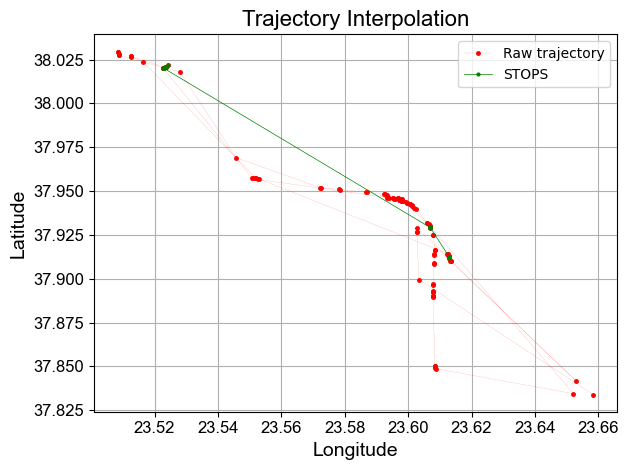

In [235]:
plt.plot(
    A['LON'], 
    A['LAT'], 
    marker='.', 
    ms=5, 
    linestyle='--', 
    color='red', 
    linewidth=0.1,
    label='Raw trajectory'
)

plt.plot(
    A.loc[A.CLUSTER>-1].LON, 
    A.loc[A.CLUSTER>-1].LAT, 
    marker='o', 
    ms=2, 
    linestyle='-', 
    color='g',
    linewidth=0.5, 
    label='STOPS'
)

plt.yticks(fontproperties='Arial', size=12)
plt.xticks(fontproperties='Arial', size=12)
plt.xlabel('Longitude', fontdict={'family': 'Arial', 'size': 14})
plt.ylabel('Latitude', fontdict={'family': 'Arial', 'size': 14})
plt.title('Trajectory Interpolation', fontdict={'family': 'Arial', 'size': 16})
plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [233]:
traj_df = TrajDataFrame(
    data=A[(A.CLUSTER != -1) & (A.CLUSTER != 0)],
    latitude="LAT",
    longitude="LON",
    datetime="EPOCH",
    user_id="CLUSTER",
    timestamp=True
) # type: ignore

In [234]:
traj_df.plot_trajectory(max_users=10, max_points=None) # type: ignore